In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
import yfinance as yf

data = yf.download(tickers = "6E=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1.19005,1.19500,1.18600,1.19030,1.19030,289430
2017-12-04,1.18785,1.18875,1.18380,1.18660,1.18660,170174
2017-12-05,1.18755,1.18855,1.18080,1.18230,1.18230,185404
2017-12-06,1.18370,1.18560,1.17880,1.17985,1.17985,197952
2017-12-07,1.18085,1.18210,1.17770,1.17790,1.17790,197235
...,...,...,...,...,...,...
2023-06-09,1.07880,1.07905,1.07475,1.07545,1.07545,230751
2023-06-12,1.07525,1.07945,1.07375,1.07600,1.07600,349852
2023-06-13,1.07600,1.08280,1.07600,1.07935,1.07935,535272


In [4]:
data = data.reset_index('Date', inplace=False)

In [5]:
df = data

In [6]:
df1=df.reset_index()['Close']

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [12]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 86ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 2/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/100
14/14 [==============================] - 1s 68ms/step - loss: 5.4970e-04 - val_loss: 0.0017
Epoch 4/100
14/14 [==============================] - 1s 64ms/step - loss: 4.2308e-04 - val_loss: 0.0015
Epoch 5/100
14/14 [==============================] - 1s 69ms/step - loss: 3.8064e-04 - val_loss: 0.0013
Epoch 6/100
14/14 [==============================] - 1s 54ms/step - loss: 3.6290e-04 - val_loss: 0.0012
Epoch 7/100
14/14 [==============================] - 1s 50ms/step - loss: 3.5506e-04 - val_loss: 0.0011
Epoch 8/100
14/14 [==============================] - 1s 55ms/step - loss: 3.5764e-04 - val_loss: 0.0011
Epoch 9/100
14/14 [==============================] - 1s 48ms/step - loss: 3.3295e-04 - val_loss: 0.0010
Epoch 10/100
14/14 [==============================] - 1s 41ms/step - los

In [14]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 9ms/step


In [15]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.0047883923152858285
Testing RMSE: 0.007434883596251015


In [18]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.004048631741450383
Testing MAE: 0.005863225861881556


In [19]:
from sklearn.metrics import mean_absolute_percentage_error
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.0047883923152858285
Testing MAPE: 0.007434883596251015


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.46386433]
101
1 day input [0.45323002 0.4434107  0.43652018 0.42842381 0.43393598 0.47304032
 0.44823411 0.41205856 0.38432397 0.38242894 0.38363479 0.38776902
 0.36537452 0.37553842 0.39379828 0.37364339 0.3758826  0.37812221
 0.36106779 0.34418586 0.34177416 0.32627017 0.34608089 0.33712325
 0.36244614 0.33867328 0.35383268 0.36744163 0.32437556 0.32248053
 0.33212734 0.35503853 0.38105059 0.3958654  0.3433246  0.35073221
 0.37450466 0.3882857  0.40241174 0.44254944 0.42825131 0.40000004
 0.41188606 0.42807922 0.42825131 0.44840661 0.4310076  0.44478906
 0.46425477 0.44806202 0.45564172 0.43049092 0.44702826 0.47700246
 0.49457356 0.47734705 0.45167958 0.47390159 0.46701106 0.47062862
 0.47441867 0.49836321 0.47252365 0.49526274 0.49009475 0.48682178
 0.47045653 0.48079252 0.501292   0.48492675 0.48854431 0.4811367
 0.46735565 0.47062862 0.44995705 0.42739004 0.43617559 0.43944856
 0.42876839 0.4036176  0.41774323 0.4211887  0.40620139 0.39707125
 0.38639108 0.38931946 0.38535732 

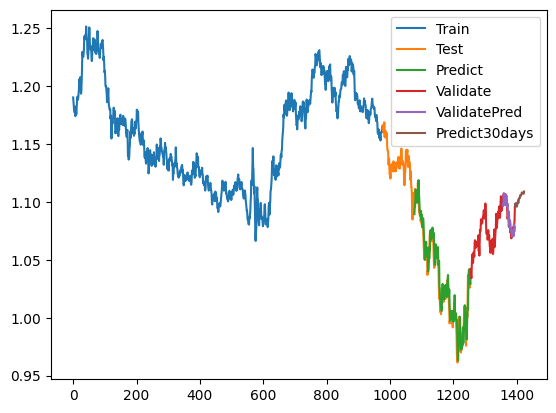

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [22]:
scaler.inverse_transform(lst_output)

array([[1.09598665],
       [1.09842512],
       [1.09855582],
       [1.0990473 ],
       [1.09739425],
       [1.09673211],
       [1.09587469],
       [1.09672726],
       [1.09847761],
       [1.09947346],
       [1.101286  ],
       [1.0990657 ],
       [1.10231534],
       [1.10236117],
       [1.10336912],
       [1.10314343],
       [1.10421811],
       [1.10588389],
       [1.10555604],
       [1.10544198],
       [1.10621806],
       [1.10699327],
       [1.10816429],
       [1.10827877],
       [1.1076206 ],
       [1.10769104],
       [1.10765648],
       [1.10710863],
       [1.10715944],
       [1.10903448]])